<a href="https://colab.research.google.com/github/terryhill89/deep-learning-challenge/blob/main/AlphabetSoupCharity_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [ ]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN', 'NAME'])
application_df.head()


,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [ ]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [ ]:
# Look at APPLICATION_TYPE value counts for binning
app_counts = application_df["APPLICATION_TYPE"].value_counts()
app_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [ ]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`

# set cutoff to 200, create dictionary from value_counts result, and initialize list for app types to replace
cutoff = 200
app_count_dict = dict(app_counts)
application_types_to_replace = []

# iterate through items in dictionary, add app types with value < cutoff to list
for key, value in app_count_dict.items():
    if value < cutoff:
        application_types_to_replace.append(key)

# create copy of df for reduced app types
reduce_app_type_df = application_df

# Replace in dataframe
for app in application_types_to_replace:
    reduce_app_type_df['APPLICATION_TYPE'] = reduce_app_type_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
reduce_app_type_df['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [ ]:
# Look at CLASSIFICATION value for binning
class_counts = reduce_app_type_df['CLASSIFICATION'].value_counts()
class_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [ ]:
# You may find it helpful to look at CLASSIFICATION value counts >1
class_counts.loc[class_counts > 1]

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
C7120       18
C1500       16
C1800       15
C6000       15
C1250       14
C8200       11
C1238       10
C1278       10
C1235        9
C1237        9
C7210        7
C2400        6
C1720        6
C4100        6
C1257        5
C1600        5
C1260        3
C2710        3
C0           3
C3200        2
C1234        2
C1246        2
C1267        2
C1256        2
Name: CLASSIFICATION, dtype: int64

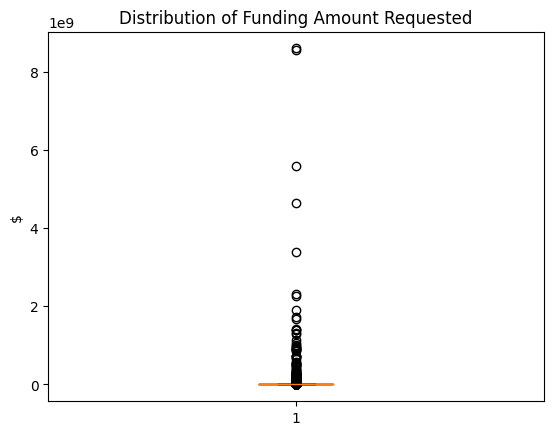

In [ ]:
# Assessing outliers for ASK_AMT var 
import numpy as np
import matplotlib.pyplot as plt

# creating boxplot for the ask amount
ask_amount = application_df['ASK_AMT'].tolist()
fig1, ax1 = plt.subplots()
ax1.set_title('Distribution of Funding Amount Requested')
ax1.set_ylabel('$')
ax1.boxplot(ask_amount)
plt.show()


In [ ]:
# Determine which data points are outside of the 1.5*IQR range
quartiles = np.quantile(ask_amount,[.25,.75])
iqr = quartiles[1]-quartiles[0]
lower_bound = quartiles[0]-(1.5*iqr)
upper_bound = quartiles[1]+(1.5*iqr)
potential_outliers = []
# potential_outliers = [potential_outliers.append(amount) if amount < lower_bound or amount > upper_bound else next for amount in ask_amount]

for amount in ask_amount:
    if amount < lower_bound or amount > upper_bound:
        potential_outliers.append(amount)

print(f"There are {len(potential_outliers)} potential outliers out of {application_df.shape[0]} records")
print(f"That is {len(potential_outliers)/application_df.shape[0]*100}% of the records")

There are 8206 potential outliers out of 34299 records
That is 23.924895769555967% of the records


In [ ]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`

# set cutoff to 1000, create dictionary from value_counts result, and initialize list for classifications to replace
cutoff = 1000
class_count_dict = dict(class_counts)
classifications_to_replace = []

# iterate through items in dictionary, add classifications with value < cutoff to list
for key, value in class_count_dict.items():
    if value < cutoff:
        classifications_to_replace.append(key)

# create copy of dataframe for reduced classifications
reduce_class_df = reduce_app_type_df

# Replace in dataframe
for cls in classifications_to_replace:
    reduce_class_df['CLASSIFICATION'] = reduce_class_df['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
reduce_class_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [ ]:
# Convert categorical data to numeric with `pd.get_dummies`
dummies_df = pd.get_dummies(reduce_class_df)
dummies_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,108590,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,1,5000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1,6692,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,1,142590,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
# Split our preprocessed data into our features and target arrays
X = dummies_df.drop('IS_SUCCESSFUL', axis=1)
y = dummies_df['IS_SUCCESSFUL']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# **Optimization Attempt 1**

#### 1st attempt at optimizing the model, add another hidden layer to the model. 

## **Compile, Train and Evaluate the Model**

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

#  build the model
nn_model_op1 = tf.keras.models.Sequential()

# First hidden layer
nn_model_op1.add(tf.keras.layers.Dense(units=80, activation="relu", input_dim=43))

# New hidden layer 2
nn_model_op1.add(tf.keras.layers.Dense(units=60, activation="relu"))

# third hidden layer
nn_model_op1.add(tf.keras.layers.Dense(units=30, activation="relu"))

# Output layer
nn_model_op1.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model_op1.summary()
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                3520      
                                                                 
 dense_1 (Dense)             (None, 60)                4860      
                                                                 
 dense_2 (Dense)             (None, 30)                1830      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
nn_model_op1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model_op1 = nn_model_op1.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 4s 2ms/step - loss: 0.5676 - accuracy: 0.7230
Epoch 2/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5543 - accuracy: 0.7295
Epoch 3/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5519 - accuracy: 0.7315
Epoch 4/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5505 - accuracy: 0.7315
Epoch 5/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5494 - accuracy: 0.7318
Epoch 6/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5483 - accuracy: 0.7328
Epoch 7/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5471 - accuracy: 0.7341
Epoch 8/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5465 - accuracy: 0.7345
Epoch 9/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5462 - accuracy: 0.7333
Epoch 10/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5456 - accura

In [ ]:
# Evaluate the model using the test data
model_loss_op1, model_accuracy_op1 = nn_model_op1.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss_op1}, Accuracy: {model_accuracy_op1}")

268/268 - 0s - loss: 0.5713 - accuracy: 0.7284 - 474ms/epoch - 2ms/step
Loss: 0.5712703466415405, Accuracy: 0.728396475315094


In [ ]:
# Export our model to HDF5 file
nn_model_op1.save('Results/AlphabetSoupCharity_Optimization1.h5')

**Results:**
* *1st optimization attempt failed. Accuracy has decreased*

# **Optimization Attempt 2**

Decrease the number of layers, then decrease neurons per layer.

## **Compile, Train and Evaluate the Model**

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

#  build the model
nn_model_op2 = tf.keras.models.Sequential()

# First hidden layer
nn_model_op2.add(tf.keras.layers.Dense(units=60, activation="relu", input_dim=43))

# Second hidden layer
nn_model_op2.add(tf.keras.layers.Dense(units=60, activation="relu"))

# Output layer
nn_model_op2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model_op2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 60)                2640      
                                                                 
 dense_5 (Dense)             (None, 60)                3660      
                                                                 
 dense_6 (Dense)             (None, 1)                 61        
                                                                 
Total params: 6,361
Trainable params: 6,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
nn_model_op2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model_op2 = nn_model_op2.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 3s 3ms/step - loss: 0.5739 - accuracy: 0.7200
Epoch 2/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5571 - accuracy: 0.7266
Epoch 3/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5532 - accuracy: 0.7304
Epoch 4/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5517 - accuracy: 0.7294
Epoch 5/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5502 - accuracy: 0.7315
Epoch 6/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5496 - accuracy: 0.7299
Epoch 7/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5480 - accuracy: 0.7316
Epoch 8/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5473 - accuracy: 0.7324
Epoch 9/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5467 - accuracy: 0.7324
Epoch 10/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5462 - accura

In [ ]:
# Evaluate the model using the test data
model_loss_op2, model_accuracy_op2 = nn_model_op2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss_op2}, Accuracy: {model_accuracy_op2}")

268/268 - 0s - loss: 0.5610 - accuracy: 0.7279 - 422ms/epoch - 2ms/step
Loss: 0.5609568357467651, Accuracy: 0.7279300093650818


In [ ]:
# Export our model to HDF5 file
nn_model_op2.save('Results/AlphabetSoupCharity_Optimization2.h5')

**Results:**
* *2nd optimization attempt failed. Decrease in Layers/neurons led to a slight decrease in the models accuracy.*



# **Optimization Attempt 3**

Start with the original model setup but drop some potentially unnecessary columns.
* Drop `STATUS` and `SPECIAL_CONSIDERATIONS` Columns because they are simple Booleans describing a single factor they don't contribute that much to the decisions of the model.


## **Reprocessing Data**

In [ ]:
# call the processed data just prior to categorical conversion and drop selected columns
op3_df = reduce_class_df.drop(['STATUS', 'SPECIAL_CONSIDERATIONS'], axis=1)

# convert categorical data to numeric
op3_dummies_df = pd.get_dummies(op3_df)
op3_dummies_df.head()

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,5000,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,108590,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,5000,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,6692,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,142590,1,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [ ]:
# Split our preprocessed data into our features and target arrays
X_op3 = op3_dummies_df.drop('IS_SUCCESSFUL', axis=1)
y_op3 = op3_dummies_df['IS_SUCCESSFUL']

# Split the preprocessed data into a training and testing dataset
X_op3_train, X_op3_test, y_op3_train, y_op3_test = train_test_split(X_op3, y_op3, random_state=1)

In [ ]:
# Create a StandardScaler instances
scaler_op3 = StandardScaler()

# Fit the StandardScaler
X_scaler_op3 = scaler_op3.fit(X_op3_train)

# Scale the data
X_op3_train_scaled = X_scaler_op3.transform(X_op3_train)
X_op3_test_scaled = X_scaler_op3.transform(X_op3_test)

## **Compile, Train and Evaluate the Model**

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

#  build the model
nn_model_op3 = tf.keras.models.Sequential()

# First hidden layer
nn_model_op3.add(tf.keras.layers.Dense(units=60, activation="relu", input_dim=40))

# Second hidden layer
nn_model_op3.add(tf.keras.layers.Dense(units=30, activation="relu"))

# Output layer
nn_model_op3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model_op3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 60)                2460      
                                                                 
 dense_8 (Dense)             (None, 30)                1830      
                                                                 
 dense_9 (Dense)             (None, 1)                 31        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
nn_model_op3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model_op3 = nn_model_op3.fit(X_op3_train_scaled, y_op3_train, epochs=100)


Epoch 1/100
804/804 [==============================] - 3s 2ms/step - loss: 0.5724 - accuracy: 0.7203
Epoch 2/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5565 - accuracy: 0.7279
Epoch 3/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5524 - accuracy: 0.7298
Epoch 4/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5512 - accuracy: 0.7306
Epoch 5/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5488 - accuracy: 0.7314
Epoch 6/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5482 - accuracy: 0.7324
Epoch 7/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5482 - accuracy: 0.7318
Epoch 8/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5470 - accuracy: 0.7326
Epoch 9/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5465 - accuracy: 0.7347
Epoch 10/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5464 - accura

In [ ]:
# Evaluate the model using the test data
model_loss_op3, model_accuracy_op3 = nn_model_op3.evaluate(X_op3_test_scaled,y_op3_test,verbose=2)
print(f"Loss: {model_loss_op3}, Accuracy: {model_accuracy_op3}")

268/268 - 0s - loss: 0.5583 - accuracy: 0.7297 - 430ms/epoch - 2ms/step
Loss: 0.5583263039588928, Accuracy: 0.72967928647995


In [ ]:
# Export our model to HDF5 file
nn_model_op3.save('Results/AlphabetSoupCharity_Optimization2.h5')

**Results:**

3rd optimization attempt has failed. Removing the status and special considerations columns from the model had very little impact on the accuracy of the model only causing a bit of an increase in accuracy.

The loss and accuracy were nearly the same as the first optimization model showing at **L:** 0.5712 and **A:** 0.7283 with a slight increase in accuracy showing at **L:** 0.5583 and **A:** 0.7296 for model 3.

# **Final Optimization Attempt**

In the final attempt Compile, Train and Evaluate the model using Automated Tuning Approach to see if the accuracy will increase.

**!pip install keras_tuner** 
and then

**import the kerastuner library**

**import keras_tuner as kt**


## **Compile, Train and Evaluate the Model using Automated Tuning Approach**


In [ ]:
# Export our model to HDF5 file
nn_model_op3.save('Results/AlphabetSoupCharity_Optimization3.h5')


In [ ]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(
        units=hp.Int('first_units',
                     min_value=2,
                     max_value=160,
                     step=2),
        activation=activation,
        input_dim=43))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=2,
            max_value=160,
            step=43),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [ ]:
!pip install keras_tuner
# Import the kerastuner library
import keras_tuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 14.7 MB/s eta 0:00:00


In [ ]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=100,
    hyperband_iterations=2)

In [37]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=200,validation_data=(X_test_scaled,y_test))

Trial 508 Complete [00h 03m 23s]
val_accuracy: 0.7313119769096375

Best val_accuracy So Far: 0.7344606518745422
Total elapsed time: 03h 27m 19s


In [39]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5620 - accuracy: 0.7345 - 445ms/epoch - 2ms/step
Loss: 0.5620214343070984, Accuracy: 0.7344606518745422


In [40]:
# Export our model to HDF5 file
best_model.save('AlphabetSoupCharity_Optimization.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Final Results:**

Final optimization attempt was ***successful***. There was a sufficent increase using the Automated Tuning Approach. I ran the automization model several times with no improvement in performence. After adjusting the model a few times I seen high increase in accuracy.
